цели и задачи проекта, описание исходных и обработанных данных и признаков.

первичный анализ признаков

первичный визуальный анализ признаков

если пришли к каким-то "инсайтам", обнаружили закономерности – изложите

описание предобработки данных

если создаются признаки, то описание этого процесса

кросс-валидация, построение кривых валидации и обучения

оценка модели с описанием выбранной метрики. Опишите простыми словами качество модели, как она может применяться

выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.

# Отчет

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import pickle
import itertools
from scipy.sparse import coo_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

## Цели и задачи проекта

Задача: идентификации пользователя.

Цели:
1. По последовательности из нескольких веб-сайтов распознать человека.
2. Получить высокую точность распознавания.


# Первичный анализ признаков

In [3]:
!pwd

/home/jovyan/work/week 7


In [4]:
PATH_TO_DATA = '/home/jovyan/work/week 5/data'

In [5]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [6]:
# Размер тренировочного и тестового датасета
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [7]:
train_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [8]:
train_df.describe()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,target
count,253561.000000,250098.000000,246919.000000,244321.000000,241829.000000,239495.000000,237297.000000,235224.000000,233084.000000,231052.000000,253561.000000
mean,3243.550144,3272.400883,3303.987757,3325.109422,3343.406035,3352.312637,3395.546771,3430.157765,3438.400088,3460.388861,0.009059
std,7247.006212,7307.480404,7347.809918,7371.245606,7379.758550,7380.413775,7435.727671,7473.417900,7471.062652,7492.447548,0.094747
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,53.000000,53.000000,53.000000,52.000000,52.000000,52.000000,55.000000,55.000000,55.000000,55.000000,0.000000
50%,677.000000,677.000000,677.000000,677.000000,678.000000,679.000000,679.000000,704.000000,733.000000,733.000000,0.000000
75%,1980.000000,1980.000000,1986.500000,1995.000000,2054.000000,2077.000000,2197.000000,2287.000000,2366.000000,2403.000000,0.000000
max,41601.000000,41600.000000,41599.000000,41599.000000,41599.000000,41600.000000,41600.000000,41601.000000,41601.000000,41601.000000,1.000000


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64

# Предобработки данных и создание новых признаков 

In [10]:
train_test_df = pd.concat([train_df, test_df])

In [11]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [12]:
from tqdm import tqdm_notebook
def csr(docs):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in tqdm_notebook(docs):
        for term in d:
            index = vocabulary.setdefault(term, term)
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr))[:,1:]

In [13]:
train_test_sparse = csr(train_test_df_sites.values)
X_train_sparse = train_test_sparse[:train_df.shape[0]]
X_test_sparse = train_test_sparse[train_df.shape[0]:]                   
y = train_df.iloc[:, -1].values
X_train_sparse.shape[0],X_test_sparse.shape[0]

(253561, 82797)

In [14]:
def freq_site(data):
    """
    Составление словаря встречаемости сайтов
    Args:
        data - DataFrame
    Return:
        sorted_alice_dict - отсортированный словарь
    """
    l1 = [list(zip(data[c].value_counts().index, data[c].value_counts().values)) for c in list(data.columns)]
    dict_site = {}
    for i in l1:
        for j in i:
            try:
                dict_site[j[0]] += j[1] 
            except:
                dict_site[j[0]] = j[1] 
    return dict_site

def create_sorted_dict(data,site_dic):
    """
    Составление словаря отсортированных сайтов
    Args:
        data - DataFrame
        site_dic - Словарь сайтов
    Return:
        Ключи словаря, значения словаря и отсортированный словарь
    """
    name_list = {}
    for name, id_ in site_dic.items():
        if id_ in data:
            name_list[name] = data[id_]

    sorted_name = {k: v for k, v in sorted(name_list.items(),key=lambda item: item[1], reverse=True)}
    keys = list(sorted_name.keys())
    values = list(sorted_name.values())
    return keys,values,sorted_name


In [15]:
# PATH_TO_DATA = '/home/jovyan/work/Финальный проект/week 5/data' 
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as dic:
     site_dic = pickle.load(dic)

#### Новые признаки:
1. start_h - Время начала сессии(утро, день, вечер, ночь).
2. start_day - День начала сессии.
3. start_m - Месяц начала сессии.
4. first_site - Первый сайт в сессии.
5. last_site - Последний сайт в сессии.
6. duration - Продолжительность сессии.
7. unique - Количество уникальных сайтов.

In [16]:
def time(x):
    if (x >= 7) & (x <= 11):
        return 1
    if (x >= 12) & (x <= 18):
        return 2
    if (x >= 19) & (x <= 23):
        return 3
    if (x >= 0) & (x <=6):
        return 4


def new_features(dataset):
    df = pd.DataFrame()
    data_timestamp = dataset[dataset.filter(like='time').columns].apply(pd.to_datetime, errors='coerce')
    data_timestamp['time10'] = data_timestamp[['time1','time10']].apply(lambda x: (x['time1'] + pd.Timedelta(minutes=30) if pd.isnull(x['time10']) else x['time10']), axis=1)
    df['start_h'] = data_timestamp['time1'].apply(lambda x: time(x.hour)).astype('int').values
    df['start_day'] = data_timestamp['time1'].apply(lambda x: x.weekday()).astype('int').values
    df['start_m'] = data_timestamp['time1'].apply(lambda x: x.month).astype('int').values
    df['first_site'] = dataset['site1']
    df['last_site'] = dataset['site10']
    df['duration'] = (data_timestamp['time10'] - data_timestamp['time1']).apply(lambda x: x.seconds/10e8)
    df['unique']= dataset[dataset.filter(like='site').columns].apply(lambda x: len(np.unique(x[~np.isnan(x)]).tolist()),axis =1)
    return df
new_train_features = new_features(train_df)
train_data = hstack([X_train_sparse,new_train_features.fillna(0)])
new_test_features = new_features(test_df)
test_data = hstack([X_test_sparse,new_test_features.fillna(0)])

# Первичный визуальный анализ признаков

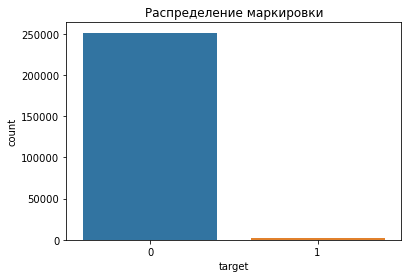

In [17]:
sns.countplot(train_df['target'])
plt.title("Распределение маркировки")
plt.show()

In [18]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [19]:
new_train_features['target'] = y

In [20]:
new_train_features

,start_h,start_day,start_m,first_site,last_site,duration,unique,target
0,1,3,2,NaN,NaN,NaN,NaN,0
1,1,5,2,718.0,NaN,1.800000e-06,1.0,0
2,2,0,12,890.0,1518.0,2.600000e-08,7.0,0
3,1,4,3,14769.0,14768.0,7.000000e-09,4.0,0
4,1,4,2,782.0,782.0,2.700000e-07,1.0,0
...,...,...,...,...,...,...,...,...
253556,1,0,11,9041.0,52.0,1.600000e-08,5.0,0
253557,2,1,3,3474.0,148.0,5.900000e-08,5.0,0
253558,2,3,9,12727.0,21.0,3.000000e-09,6.0,0
253559,2,3,12,2661.0,NaN,1.800000e-06,3.0,0


#### Начало сессии Alice

In [21]:
alice_time = new_train_features[new_train_features['target'] == 1]

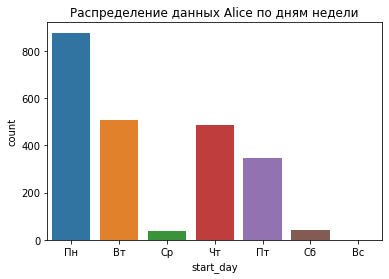

In [22]:
sns.countplot(alice_time['start_day']).set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.title("Распределение данных Alice по дням недели")
plt.show()

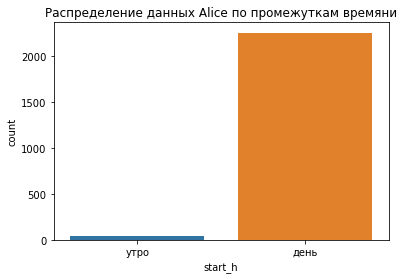

In [23]:
sns.countplot(alice_time['start_h']).set_xticklabels(['утро', 'день', 'вечер', 'ночь'])
plt.title("Распределение данных Alice по промежуткам времяни")
plt.show()

#### Начало сессии не Alice

In [24]:
not_alice_time = new_train_features[new_train_features['target'] == 0]

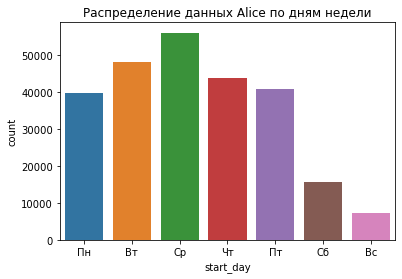

In [25]:
sns.countplot(not_alice_time['start_day']).set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.title("Распределение данных Alice по дням недели")
plt.show()

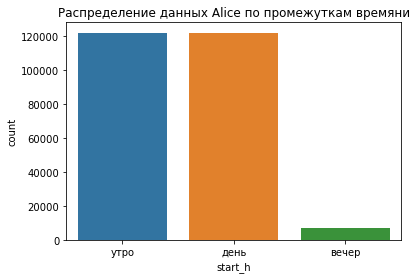

In [26]:
sns.countplot(not_alice_time['start_h']).set_xticklabels(['утро', 'день', 'вечер', 'ночь'])
plt.title("Распределение данных Alice по промежуткам времяни")
plt.show()

# Сравнение сессий Alice с чужими

In [27]:
# ALICE
alice = train_df[train_df['target'] == 1]
alice_site = alice[alice.filter(like='site').columns]
alice_time = new_train_features[new_train_features['target'] == 1]

# Alice top-10 sites
top_10_site_Alice = dict(itertools.islice(freq_site(alice_site).items(), 10))
Alice_keys,Alice_values,sorted_top_10_site_Alice_name = create_sorted_dict(top_10_site_Alice,site_dic)

# Alice first sites
alice_time_top_first_site = dict(alice_time.first_site.value_counts().iloc[:10])
Alice_keys_f,Alice_values_f,sorted_first_site_Alice_name = create_sorted_dict(alice_time_top_first_site,site_dic)

# Alice last sites
alice_time_top_last_site = dict(alice_time.last_site.value_counts().iloc[:10])
Alice_keys_l,Alice_values_l,sorted_first_site_Alice_name = create_sorted_dict(alice_time_top_last_site,site_dic)


# NOT ALICE
not_alice = train_df[train_df['target'] == 0]
not_alice_site = not_alice[not_alice.filter(like='site').columns]
not_alice_time = new_train_features[new_train_features['target'] == 0]
# not Alice top-10 sites
top_10_site_not_Alice = dict(itertools.islice(freq_site(not_alice_site).items(), 10))
not_Alice_keys,not_Alice_values,sorted_top_10_site_not_Alice_name = create_sorted_dict(top_10_site_not_Alice,site_dic)

# Alice first sites
not_alice_time_top_first_site = dict(not_alice_time.first_site.value_counts().iloc[:10])
not_Alice_keys_f,not_Alice_values_f,sorted_first_site_not_Alice_name = create_sorted_dict(not_alice_time_top_first_site,site_dic)

# Alice last sites
not_alice_time_top_last_site = dict(not_alice_time.last_site.value_counts().iloc[:10])
not_Alice_keys_l,not_Alice_values_l,sorted_first_site_not_Alice_name = create_sorted_dict(not_alice_time_top_last_site,site_dic)

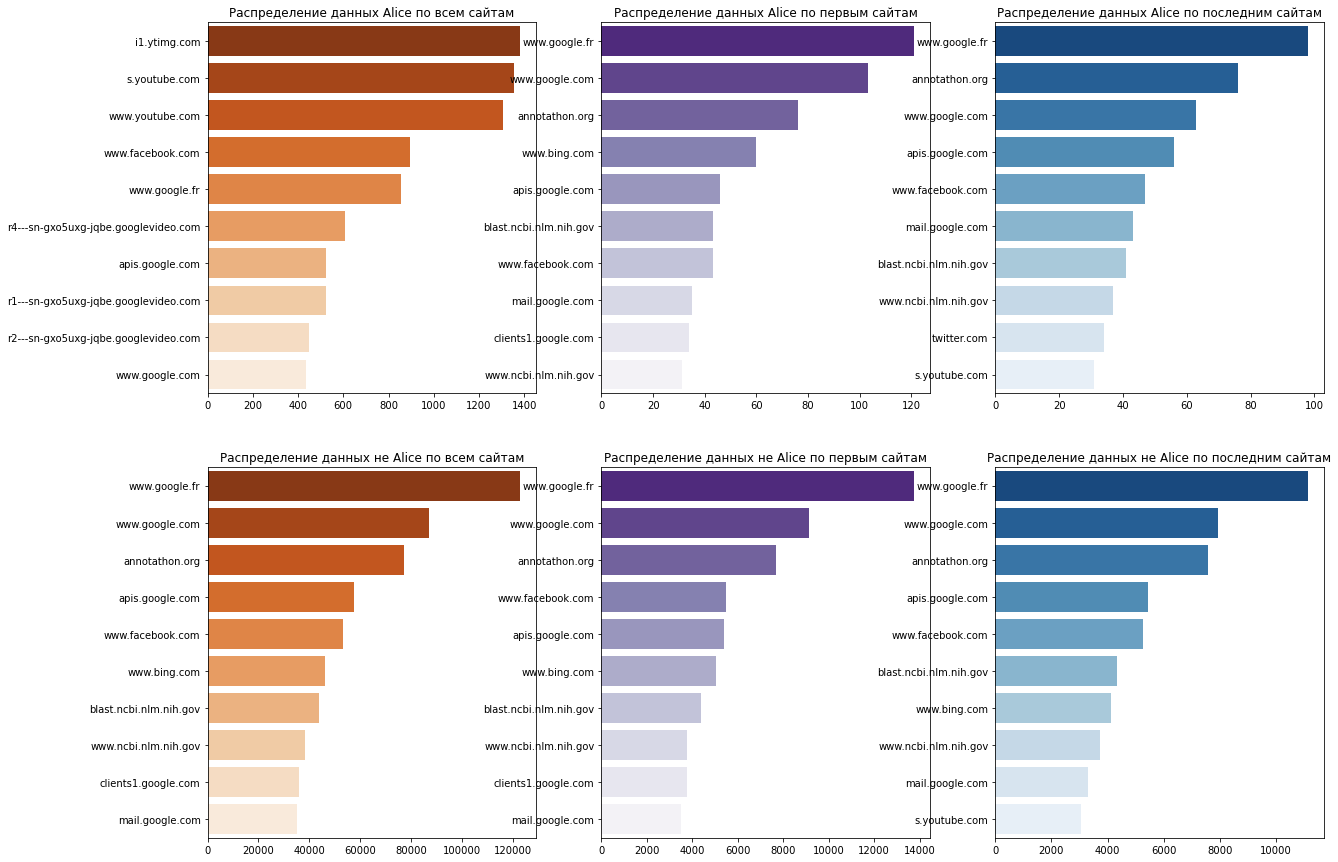

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
# Alice top-10 sites
sns.barplot(Alice_values,Alice_keys, palette="Oranges_r", ax=axes[0, 0]).set_title("Распределение данных Alice по всем сайтам")
# Alice first sites
sns.barplot(Alice_values_f,Alice_keys_f, palette="Purples_r", ax=axes[0, 1]).set_title("Распределение данных Alice по первым сайтам")
# Alice last sites
sns.barplot(Alice_values_l,Alice_keys_l, palette="Blues_r", ax=axes[0, 2]).set_title("Распределение данных Alice по последним сайтам")

# not_Alice top-10 sites
sns.barplot(not_Alice_values,not_Alice_keys, palette="Oranges_r", ax=axes[1, 0]).set_title("Распределение данных не Alice по всем сайтам")
# not_Alice first sites
sns.barplot(not_Alice_values_f,not_Alice_keys_f, palette="Purples_r", ax=axes[1, 1]).set_title("Распределение данных не Alice по первым сайтам")
# not_Alice last sites
sns.barplot(not_Alice_values_l,not_Alice_keys_l, palette="Blues_r", ax=axes[1, 2]).set_title("Распределение данных не Alice по последним сайтам")
plt.show()

Начало и конец сессия для Alice схожее с чужими сессиями, но типичные посещаемые сайты не похожи.

# Кросс-валидация, построение кривых валидации и обучения

In [34]:
def cross_validation(X,y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=17)
    C = np.linspace(0.1, 10.0, num=20)
    cv_list,test_list = {},{}
    
    for c in tqdm_notebook(C):
        lg = LogisticRegression(C=c, random_state=17, solver='liblinear')
        cv_list[c] = np.mean(cross_val_score(lg, X_train, y_train, cv=3, scoring='roc_auc'))
        test_list[c] = roc_auc_score(y_test, lg.fit(X_train,y_train).predict_proba(X_test)[:, 1])
    
    plt.plot(C, list(cv_list.values()), label='CV')
    plt.plot(C, list(test_list.values()), label='test')
    plt.title('График зависимости предсказаний от параметра C')
    plt.xlabel('Параметр С')
    plt.ylabel('ROC AUC score')
    plt.legend()
    max_cv = max(cv_list, key=cv_list.get)
    max_test = max(test_list, key=test_list.get)
    print('MAX C and score in cv = {}, MAX C and score in test = {}'.format((max_cv ,cv_list[max_cv]),
                                                                            (max_test,test_list[max_test])))
    return cv_list[max_cv],test_list[max_test]


MAX C and score in cv = (8.957894736842105, 0.9678048692522986), MAX C and score in test = (8.436842105263159, 0.9758839248315684)


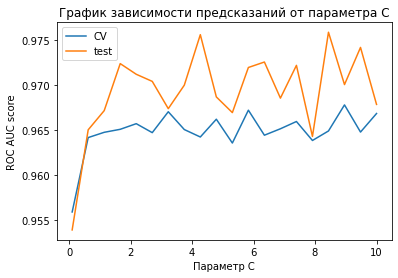

In [35]:
max_cv,max_test = cross_validation(train_data,y)

При увеличении параметра C метрика слабо изменяется 

# Оценка модели с описанием выбранной метрики

Несбалансированных данные и требуется предсказать вероятность класса. Для этого больше подходит ROC AUC.

In [31]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [40]:
lg = LogisticRegression(C=max_cv, random_state=17, solver='liblinear')
pred = lg.fit(train_data,y).predict_proba(test_data)[:, 1]

In [41]:
write_to_submission_file(pred, 'sub.csv')

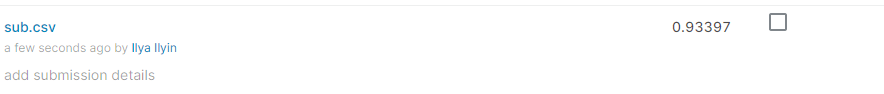

In [42]:
lg2 = LogisticRegression(C=1, random_state=17, solver='liblinear')
pred2 = lg2.fit(train_data,y).predict_proba(test_data)[:, 1]

In [43]:
write_to_submission_file(pred2, 'sub2.csv')

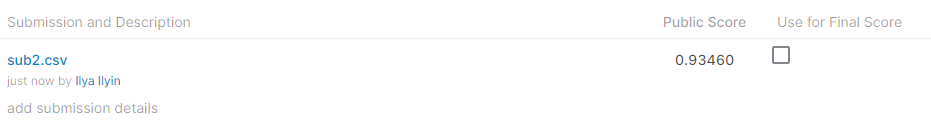

# Вывод

Модель можно улучшить, попробовать бустинг, попробовать выявить закономерности в посещение сайтов.
Данную модель можно использовать как отправную точку, логистическая регрессия простой алгоритм, но при этом дает неплохой результат.